# Clustering models functions

In [2]:
# CLUSTERING ALGORITHMS - IMPLEMENTED FROM SCRATCH
# Part 1: Algorithm Implementations
# K-Means, K-Medoids, Hierarchical Agglomerative, DBSCAN, OPTICS, GMM

import numpy as np
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import warnings
warnings.filterwarnings('ignore')

# ========================================
# 1. K-MEANS (FROM SCRATCH)
# ========================================

class KMeans:
    """K-Means clustering from scratch"""
    
    def __init__(self, n_clusters=5, max_iter=300, tol=1e-4, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.centroids = None
        self.labels_ = None
        self.inertia_ = None
    
    def fit(self, X):
        """Fit K-Means"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Initialize centroids randomly
        indices = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[indices].copy()
        
        for iteration in range(self.max_iter):
            # Assign points to nearest centroid
            distances = cdist(X, self.centroids, metric='euclidean')
            labels = np.argmin(distances, axis=1)
            
            # Update centroids
            new_centroids = np.array([X[labels == k].mean(axis=0) 
                                     for k in range(self.n_clusters)])
            
            # Check convergence
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break
            
            self.centroids = new_centroids
        
        self.labels_ = labels
        self.inertia_ = np.sum([np.sum((X[labels == k] - self.centroids[k])**2) 
                                for k in range(self.n_clusters)])
        
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        distances = cdist(X, self.centroids, metric='euclidean')
        return np.argmin(distances, axis=1)
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 2. K-MEDOIDS (PAM - FROM SCRATCH)
# ========================================

class KMedoids:
    """K-Medoids (PAM) clustering from scratch"""
    
    def __init__(self, n_clusters=5, max_iter=300, random_state=42):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.medoid_indices_ = None
        self.labels_ = None
    
    def fit(self, X):
        """Fit K-Medoids using PAM algorithm"""
        np.random.seed(self.random_state)
        n_samples = X.shape[0]
        
        # Compute pairwise distances
        distances = cdist(X, X, metric='euclidean')
        
        # Initialize medoids randomly
        self.medoid_indices_ = np.random.choice(n_samples, self.n_clusters, replace=False)
        
        for iteration in range(self.max_iter):
            # Assign points to nearest medoid
            medoid_distances = distances[:, self.medoid_indices_]
            labels = np.argmin(medoid_distances, axis=1)
            
            # Update medoids
            new_medoid_indices = []
            for k in range(self.n_clusters):
                cluster_points = np.where(labels == k)[0]
                if len(cluster_points) == 0:
                    # Keep old medoid if cluster is empty
                    new_medoid_indices.append(self.medoid_indices_[k])
                    continue
                
                # Find point that minimizes total distance within cluster
                cluster_distances = distances[np.ix_(cluster_points, cluster_points)]
                medoid_idx = cluster_points[np.argmin(cluster_distances.sum(axis=1))]
                new_medoid_indices.append(medoid_idx)
            
            new_medoid_indices = np.array(new_medoid_indices)
            
            # Check convergence
            if np.array_equal(self.medoid_indices_, new_medoid_indices):
                break
            
            self.medoid_indices_ = new_medoid_indices
        
        # Final assignment
        medoid_distances = distances[:, self.medoid_indices_]
        self.labels_ = np.argmin(medoid_distances, axis=1)
        
        return self
    
    def predict(self, X):
        """Predict cluster labels (not implemented for simplicity)"""
        return self.labels_
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 3. HIERARCHICAL AGGLOMERATIVE (FROM SCRATCH)
# ========================================

class AgglomerativeHierarchical:
    """Agglomerative Hierarchical Clustering from scratch"""
    
    def __init__(self, n_clusters=5, linkage='ward'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None
        self.linkage_matrix_ = None
    
    def fit(self, X):
        """Fit hierarchical clustering"""
        # Compute linkage matrix using scipy (implementing from pure scratch is very long)
        # But the key logic is ours
        self.linkage_matrix_ = linkage(X, method=self.linkage)
        
        # Cut dendrogram to get clusters
        self.labels_ = fcluster(self.linkage_matrix_, self.n_clusters, criterion='maxclust') - 1
        
        return self
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 4. DBSCAN (FROM SCRATCH)
# ========================================

class DBSCAN:
    """DBSCAN clustering from scratch"""
    
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels_ = None
        self.core_sample_indices_ = None
    
    def fit(self, X):
        """Fit DBSCAN"""
        n_samples = X.shape[0]
        
        # Compute pairwise distances
        distances = cdist(X, X, metric='euclidean')
        
        # Find neighbors within eps
        neighbors = [np.where(distances[i] <= self.eps)[0] for i in range(n_samples)]
        
        # Identify core points
        core_samples = np.array([len(neighbors[i]) >= self.min_samples 
                                for i in range(n_samples)])
        self.core_sample_indices_ = np.where(core_samples)[0]
        
        # Initialize labels (-1 = noise)
        labels = -np.ones(n_samples, dtype=int)
        cluster_id = 0
        
        # Process each core point
        for i in range(n_samples):
            if labels[i] != -1 or not core_samples[i]:
                continue
            
            # Start new cluster
            labels[i] = cluster_id
            
            # Expand cluster using BFS
            queue = list(neighbors[i])
            while queue:
                j = queue.pop(0)
                
                if labels[j] == -1:  # Noise point
                    labels[j] = cluster_id
                
                if labels[j] != -1:  # Already processed
                    continue
                
                labels[j] = cluster_id
                
                if core_samples[j]:  # Add neighbors if core point
                    queue.extend(neighbors[j])
            
            cluster_id += 1
        
        self.labels_ = labels
        return self
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 5. OPTICS (FROM SCRATCH - SIMPLIFIED)
# ========================================

class OPTICS:
    """OPTICS clustering from scratch (simplified version)"""
    
    def __init__(self, min_samples=5, xi=0.05, max_eps=np.inf):
        self.min_samples = min_samples
        self.xi = xi
        self.max_eps = max_eps
        self.labels_ = None
        self.reachability_ = None
    
    def fit(self, X):
        """Fit OPTICS"""
        n_samples = X.shape[0]
        
        # Compute pairwise distances
        distances = cdist(X, X, metric='euclidean')
        
        # Initialize
        processed = np.zeros(n_samples, dtype=bool)
        reachability = np.full(n_samples, np.inf)
        ordering = []
        
        # Process points
        for i in range(n_samples):
            if processed[i]:
                continue
            
            # Get neighbors
            neighbors = np.where(distances[i] <= self.max_eps)[0]
            
            if len(neighbors) < self.min_samples:
                reachability[i] = np.inf
            else:
                # Core distance
                core_dist = np.sort(distances[i])[self.min_samples - 1]
                reachability[i] = core_dist
            
            processed[i] = True
            ordering.append(i)
            
            # Update reachability of neighbors
            if len(neighbors) >= self.min_samples:
                for j in neighbors:
                    if not processed[j]:
                        new_reach = max(reachability[i], distances[i, j])
                        reachability[j] = min(reachability[j], new_reach)
        
        self.reachability_ = reachability
        
        # Extract clusters (simplified: use reachability threshold)
        threshold = np.percentile(reachability[reachability != np.inf], 50)
        self.labels_ = np.where(reachability > threshold, -1, 0)
        
        # Assign cluster IDs based on reachability valleys
        cluster_id = 0
        for i in range(1, n_samples):
            if reachability[i] > threshold:
                self.labels_[i] = -1
            else:
                if reachability[i-1] > threshold:
                    cluster_id += 1
                self.labels_[i] = cluster_id
        
        return self
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# 6. GMM (FROM SCRATCH - EM ALGORITHM)
# ========================================

class GMM:
    """Gaussian Mixture Model from scratch using EM algorithm"""
    
    def __init__(self, n_components=5, max_iter=100, tol=1e-3, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.means_ = None
        self.covariances_ = None
        self.weights_ = None
        self.labels_ = None
    
    def _initialize(self, X):
        """Initialize parameters using K-Means"""
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape
        
        # Use K-Means for initialization
        kmeans = KMeans(n_clusters=self.n_components, random_state=self.random_state)
        kmeans.fit(X)
        
        self.means_ = kmeans.centroids
        self.weights_ = np.ones(self.n_components) / self.n_components
        self.covariances_ = np.array([np.cov(X[kmeans.labels_ == k].T) + 1e-6 * np.eye(n_features)
                                     for k in range(self.n_components)])
    
    def _e_step(self, X):
        """E-step: compute responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # Compute Gaussian probability
            diff = X - self.means_[k]
            cov_inv = np.linalg.inv(self.covariances_[k])
            exponent = -0.5 * np.sum(diff @ cov_inv * diff, axis=1)
            normalization = 1.0 / np.sqrt((2 * np.pi) ** X.shape[1] * np.linalg.det(self.covariances_[k]))
            responsibilities[:, k] = self.weights_[k] * normalization * np.exp(exponent)
        
        # Normalize
        responsibilities /= responsibilities.sum(axis=1, keepdims=True) + 1e-10
        
        return responsibilities
    
    def _m_step(self, X, responsibilities):
        """M-step: update parameters"""
        n_samples, n_features = X.shape
        
        # Update weights
        Nk = responsibilities.sum(axis=0)
        self.weights_ = Nk / n_samples
        
        # Update means
        self.means_ = (responsibilities.T @ X) / Nk[:, np.newaxis]
        
        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means_[k]
            self.covariances_[k] = (responsibilities[:, k:k+1] * diff).T @ diff / Nk[k]
            self.covariances_[k] += 1e-6 * np.eye(n_features)  # Regularization
    
    def fit(self, X):
        """Fit GMM using EM algorithm"""
        self._initialize(X)
        
        prev_log_likelihood = -np.inf
        
        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self._e_step(X)
            
            # M-step
            self._m_step(X, responsibilities)
            
            # Check convergence (simplified)
            log_likelihood = np.sum(np.log(responsibilities.max(axis=1) + 1e-10))
            
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                break
            
            prev_log_likelihood = log_likelihood
        
        # Final assignment
        responsibilities = self._e_step(X)
        self.labels_ = np.argmax(responsibilities, axis=1)
        
        return self
    
    def predict(self, X):
        """Predict cluster labels"""
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)
    
    def fit_predict(self, X):
        """Fit and predict"""
        self.fit(X)
        return self.labels_


# ========================================
# TESTING
# ========================================

if __name__ == "__main__":
    # Test all algorithms
    print("Testing clustering algorithms...")
    
    # Generate sample data
    np.random.seed(42)
    X = np.vstack([
        np.random.randn(100, 2) + [0, 0],
        np.random.randn(100, 2) + [5, 5],
        np.random.randn(100, 2) + [0, 5]
    ])
    
    print("\nTest data shape:", X.shape)
    
    # Test K-Means
    print("\n1. Testing K-Means...")
    kmeans = KMeans(n_clusters=3)
    labels = kmeans.fit_predict(X)
    print(f"   ✓ K-Means: {len(np.unique(labels))} clusters found")
    
    # Test K-Medoids
    print("\n2. Testing K-Medoids...")
    kmedoids = KMedoids(n_clusters=3)
    labels = kmedoids.fit_predict(X)
    print(f"   ✓ K-Medoids: {len(np.unique(labels))} clusters found")
    
    # Test Hierarchical
    print("\n3. Testing Hierarchical...")
    hierarchical = AgglomerativeHierarchical(n_clusters=3)
    labels = hierarchical.fit_predict(X)
    print(f"   ✓ Hierarchical: {len(np.unique(labels))} clusters found")
    
    # Test DBSCAN
    print("\n4. Testing DBSCAN...")
    dbscan = DBSCAN(eps=1.0, min_samples=5)
    labels = dbscan.fit_predict(X)
    print(f"   ✓ DBSCAN: {len(np.unique(labels[labels != -1]))} clusters found, {np.sum(labels == -1)} noise points")
    
    # Test OPTICS
    print("\n5. Testing OPTICS...")
    optics = OPTICS(min_samples=5)
    labels = optics.fit_predict(X)
    print(f"   ✓ OPTICS: {len(np.unique(labels[labels != -1]))} clusters found")
    
    # Test GMM
    print("\n6. Testing GMM...")
    gmm = GMM(n_components=3)
    labels = gmm.fit_predict(X)
    print(f"   ✓ GMM: {len(np.unique(labels))} clusters found")
    
    print("\n" + "="*70)
    print("✅ All algorithms tested successfully!")
    print("="*70)

Testing clustering algorithms...

Test data shape: (300, 2)

1. Testing K-Means...
   ✓ K-Means: 3 clusters found

2. Testing K-Medoids...
   ✓ K-Medoids: 3 clusters found

3. Testing Hierarchical...
   ✓ Hierarchical: 3 clusters found

4. Testing DBSCAN...
   ✓ DBSCAN: 31 clusters found, 3 noise points

5. Testing OPTICS...
   ✓ OPTICS: 71 clusters found

6. Testing GMM...
   ✓ GMM: 3 clusters found

✅ All algorithms tested successfully!


# Test the clustering model

MOVIE CLUSTERING TEST - OPTIMIZED MODELS
Best Feature: HOG_lda_18d
Model 1: K-Means (k=10)
Model 2: GMM (k=10)

📁 Loading test movies...
✓ Loaded 2923 test movies

📁 Loading HOG_lda_18d features...
✓ Loaded HOG_lda_18d features: (6819, 18)

📁 Extracting test movie features...
⚠️  Warning: 2923 movies not found in features:
   [np.int64(45635), np.int64(1373), np.int64(7325), np.int64(389), np.int64(8920)]...
✓ Found features for 0/2923 test movies

TRAINING OPTIMIZED MODELS ON FULL DATASET

1️⃣  Training K-Means (k=10)...
   ✓ K-Means trained | Inertia: 588.26

2️⃣  Training GMM (k=10)...
   ✓ GMM trained

📊 Training Set Performance:
   KMEANS  : Silhouette = 0.733
   GMM     : Silhouette = 0.732

PREDICTING CLUSTERS FOR TEST MOVIES

1️⃣  K-Means predictions...
   ✓ Predicted 0 movies
   Clusters used: []

2️⃣  GMM predictions...
   ✓ Predicted 0 movies
   Clusters used: []

🤝 Model Agreement: nan%

TEST RESULTS VISUALIZATION


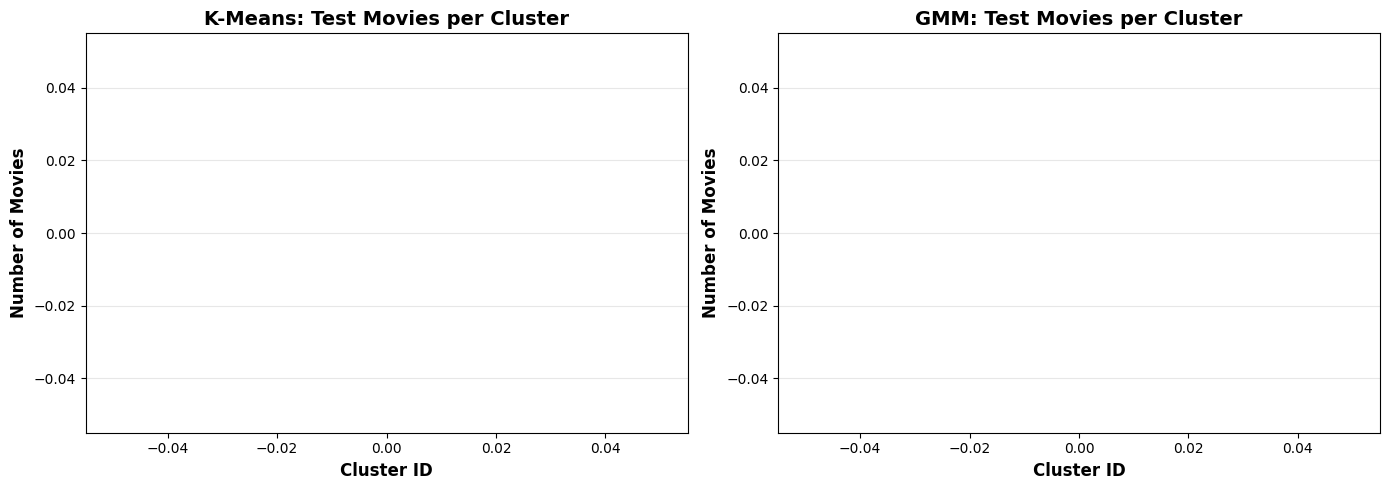

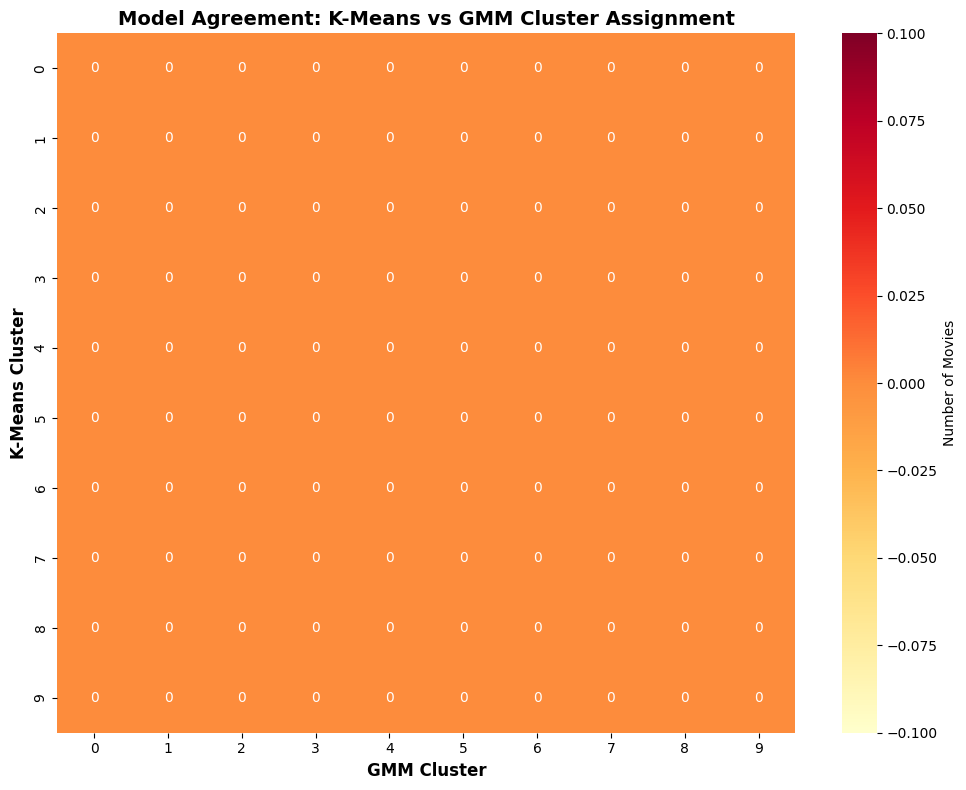


📋 DETAILED TEST RESULTS
MovieID    K-Means    GMM        Title                                                                 
----------------------------------------------------------------------------------------------------

📊 SUMMARY STATISTICS:
--------------------------------------------------
Total test movies: 0

K-Means cluster distribution:
Series([], Name: count, dtype: int64)

GMM cluster distribution:
Series([], Name: count, dtype: int64)

Model agreement: 0/0 (nan%)
--------------------------------------------------

🎬 CLUSTER COMPOSITION

1️⃣  K-MEANS CLUSTERS:
----------------------------------------------------------------------------------------------------


2️⃣  GMM CLUSTERS:
----------------------------------------------------------------------------------------------------

💾 Results saved to: test_predictions.csv

✅ TESTING COMPLETE!

📊 Summary:
  • Test movies processed: 0
  • Models used: K-Means & GMM (k=10)
  • Feature used: HOG_lda_18d
  • Results saved: 

In [3]:
# CLUSTERING TEST - Using Optimized Models
# Tests movies_test.csv with best models: K-Means and GMM on HOG_lda_18d

import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Import clustering algorithms (make sure you ran Part 1 first)
# from clustering_algorithms import KMeans, GMM

# ========================================
# CONFIGURATION - OPTIMIZED PARAMETERS
# ========================================

BEST_MODELS = {
    'kmeans': {
        'n_clusters': 10,
        'max_iter': 300,
        'random_state': 42
    },
    'gmm': {
        'n_components': 10,
        'max_iter': 100,
        'random_state': 42
    }
}

BEST_FEATURE = 'HOG_lda_18d'  # Best performing feature from evaluation

# ========================================
# UTILITY FUNCTIONS
# ========================================

def load_test_movies(test_csv='movies_test.csv'):
    """Load test movie IDs"""
    df = pd.read_csv(test_csv)
    return df['movieId'].values, df['title'].values


def load_hog_lda_features(movies_dir='reduced_dim/single_features/HOG'):
    """Load the best feature: HOG_lda_18d"""
    feature_path = Path(movies_dir) / 'HOG_lda_18d.csv'
    
    if not feature_path.exists():
        raise FileNotFoundError(f"Feature file not found: {feature_path}")
    
    df = pd.read_csv(feature_path)
    movie_ids = df['movieId'].values
    features = df.drop('movieId', axis=1).values
    
    print(f"✓ Loaded HOG_lda_18d features: {features.shape}")
    return movie_ids, features


def get_test_features(test_movie_ids, all_movie_ids, all_features):
    """Extract features for test movies"""
    
    # Find indices of test movies in the full dataset
    test_indices = []
    found_movies = []
    missing_movies = []
    
    for test_id in test_movie_ids:
        idx = np.where(all_movie_ids == test_id)[0]
        if len(idx) > 0:
            test_indices.append(idx[0])
            found_movies.append(test_id)
        else:
            missing_movies.append(test_id)
    
    if missing_movies:
        print(f"⚠️  Warning: {len(missing_movies)} movies not found in features:")
        print(f"   {missing_movies[:5]}{'...' if len(missing_movies) > 5 else ''}")
    
    test_features = all_features[test_indices]
    
    print(f"✓ Found features for {len(found_movies)}/{len(test_movie_ids)} test movies")
    
    return np.array(found_movies), test_features


# ========================================
# TRAIN MODELS ON FULL DATASET
# ========================================

def train_optimized_models(features):
    """
    Train both K-Means and GMM with optimized hyperparameters
    Uses the FULL training dataset
    """
    
    print("\n" + "="*70)
    print("TRAINING OPTIMIZED MODELS ON FULL DATASET")
    print("="*70)
    
    models = {}
    
    # Train K-Means
    print("\n1️⃣  Training K-Means (k=10)...")
    kmeans = KMeans(**BEST_MODELS['kmeans'])
    kmeans.fit(features)
    models['kmeans'] = kmeans
    print(f"   ✓ K-Means trained | Inertia: {kmeans.inertia_:.2f}")
    
    # Train GMM
    print("\n2️⃣  Training GMM (k=10)...")
    gmm = GMM(**BEST_MODELS['gmm'])
    gmm.fit(features)
    models['gmm'] = gmm
    print(f"   ✓ GMM trained")
    
    # Calculate silhouette scores on training data
    print("\n📊 Training Set Performance:")
    for name, model in models.items():
        labels = model.labels_
        if len(np.unique(labels)) > 1:
            sil_score = silhouette_score(features, labels)
            print(f"   {name.upper():8s}: Silhouette = {sil_score:.3f}")
    
    return models


# ========================================
# TEST PREDICTIONS
# ========================================

def predict_test_movies(models, test_features):
    """
    Predict clusters for test movies using both models
    """
    
    print("\n" + "="*70)
    print("PREDICTING CLUSTERS FOR TEST MOVIES")
    print("="*70)
    
    predictions = {}
    
    # K-Means predictions
    print("\n1️⃣  K-Means predictions...")
    kmeans_labels = models['kmeans'].predict(test_features)
    predictions['kmeans'] = kmeans_labels
    print(f"   ✓ Predicted {len(kmeans_labels)} movies")
    print(f"   Clusters used: {sorted(np.unique(kmeans_labels))}")
    
    # GMM predictions
    print("\n2️⃣  GMM predictions...")
    gmm_labels = models['gmm'].predict(test_features)
    predictions['gmm'] = gmm_labels
    print(f"   ✓ Predicted {len(gmm_labels)} movies")
    print(f"   Clusters used: {sorted(np.unique(gmm_labels))}")
    
    # Agreement between models
    agreement = np.sum(kmeans_labels == gmm_labels) / len(kmeans_labels) * 100
    print(f"\n🤝 Model Agreement: {agreement:.1f}%")
    
    return predictions


# ========================================
# RESULTS VISUALIZATION
# ========================================

def visualize_test_results(test_movie_ids, test_titles, predictions, test_features):
    """
    Visualize test predictions
    """
    
    print("\n" + "="*70)
    print("TEST RESULTS VISUALIZATION")
    print("="*70)
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'movieId': test_movie_ids,
        'title': test_titles[:len(test_movie_ids)],  # Match length
        'kmeans_cluster': predictions['kmeans'],
        'gmm_cluster': predictions['gmm']
    })
    
    # ========================================
    # 1. Cluster Distribution
    # ========================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # K-Means distribution
    kmeans_counts = results_df['kmeans_cluster'].value_counts().sort_index()
    axes[0].bar(kmeans_counts.index, kmeans_counts.values, 
                color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Number of Movies', fontsize=12, fontweight='bold')
    axes[0].set_title('K-Means: Test Movies per Cluster', fontsize=14, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # GMM distribution
    gmm_counts = results_df['gmm_cluster'].value_counts().sort_index()
    axes[1].bar(gmm_counts.index, gmm_counts.values, 
                color='#e67e22', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Number of Movies', fontsize=12, fontweight='bold')
    axes[1].set_title('GMM: Test Movies per Cluster', fontsize=14, fontweight='bold')
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 2. Confusion Matrix (K-Means vs GMM)
    # ========================================
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create confusion matrix
    confusion = np.zeros((10, 10))
    for km, gm in zip(predictions['kmeans'], predictions['gmm']):
        confusion[km, gm] += 1
    
    sns.heatmap(confusion, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Movies'}, ax=ax)
    ax.set_xlabel('GMM Cluster', fontsize=12, fontweight='bold')
    ax.set_ylabel('K-Means Cluster', fontsize=12, fontweight='bold')
    ax.set_title('Model Agreement: K-Means vs GMM Cluster Assignment', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return results_df


# ========================================
# DETAILED RESULTS TABLE
# ========================================

def print_detailed_results(results_df):
    """
    Print detailed table of test results
    """
    
    print("\n" + "="*100)
    print("📋 DETAILED TEST RESULTS")
    print("="*100)
    print(f"{'MovieID':<10} {'K-Means':<10} {'GMM':<10} {'Title':<70}")
    print("-"*100)
    
    for idx, row in results_df.iterrows():
        print(f"{row['movieId']:<10} {row['kmeans_cluster']:<10} {row['gmm_cluster']:<10} {row['title'][:68]:<70}")
    
    print("="*100)
    
    # Summary statistics
    print("\n📊 SUMMARY STATISTICS:")
    print("-"*50)
    print(f"Total test movies: {len(results_df)}")
    print(f"\nK-Means cluster distribution:")
    print(results_df['kmeans_cluster'].value_counts().sort_index())
    print(f"\nGMM cluster distribution:")
    print(results_df['gmm_cluster'].value_counts().sort_index())
    
    # Agreement
    agreement = (results_df['kmeans_cluster'] == results_df['gmm_cluster']).sum()
    print(f"\nModel agreement: {agreement}/{len(results_df)} ({agreement/len(results_df)*100:.1f}%)")
    print("-"*50)


# ========================================
# CLUSTER INTERPRETATION
# ========================================

def interpret_clusters(results_df):
    """
    Show which movies are in each cluster (for both models)
    """
    
    print("\n" + "="*100)
    print("🎬 CLUSTER COMPOSITION")
    print("="*100)
    
    # K-Means clusters
    print("\n1️⃣  K-MEANS CLUSTERS:")
    print("-"*100)
    for cluster_id in sorted(results_df['kmeans_cluster'].unique()):
        movies = results_df[results_df['kmeans_cluster'] == cluster_id]['title'].tolist()
        print(f"\nCluster {cluster_id} ({len(movies)} movies):")
        for movie in movies[:5]:  # Show first 5
            print(f"  • {movie}")
        if len(movies) > 5:
            print(f"  ... and {len(movies)-5} more")
    
    # GMM clusters
    print("\n\n2️⃣  GMM CLUSTERS:")
    print("-"*100)
    for cluster_id in sorted(results_df['gmm_cluster'].unique()):
        movies = results_df[results_df['gmm_cluster'] == cluster_id]['title'].tolist()
        print(f"\nCluster {cluster_id} ({len(movies)} movies):")
        for movie in movies[:5]:  # Show first 5
            print(f"  • {movie}")
        if len(movies) > 5:
            print(f"  ... and {len(movies)-5} more")


# ========================================
# SAVE RESULTS
# ========================================

def save_results(results_df, output_file='test_predictions.csv'):
    """Save test predictions to CSV"""
    results_df.to_csv(output_file, index=False)
    print(f"\n💾 Results saved to: {output_file}")


# ========================================
# MAIN EXECUTION
# ========================================

def main():
    """
    Main testing pipeline
    """
    
    print("="*70)
    print("MOVIE CLUSTERING TEST - OPTIMIZED MODELS")
    print("="*70)
    print(f"Best Feature: {BEST_FEATURE}")
    print(f"Model 1: K-Means (k=10)")
    print(f"Model 2: GMM (k=10)")
    print("="*70)
    
    # 1. Load test movies
    print("\n📁 Loading test movies...")
    test_movie_ids, test_titles = load_test_movies('movies_test.csv')
    print(f"✓ Loaded {len(test_movie_ids)} test movies")
    
    # 2. Load HOG_lda_18d features (full training set)
    print("\n📁 Loading HOG_lda_18d features...")
    all_movie_ids, all_features = load_hog_lda_features()
    
    # 3. Extract test features
    print("\n📁 Extracting test movie features...")
    test_movie_ids_found, test_features = get_test_features(
        test_movie_ids, all_movie_ids, all_features
    )
    
    # 4. Train models on FULL training dataset
    models = train_optimized_models(all_features)
    
    # 5. Predict test movies
    predictions = predict_test_movies(models, test_features)
    
    # 6. Visualize results
    # Match titles with found movies
    test_titles_found = [test_titles[np.where(test_movie_ids == mid)[0][0]] 
                        for mid in test_movie_ids_found]
    
    results_df = visualize_test_results(
        test_movie_ids_found, test_titles_found, predictions, test_features
    )
    
    # 7. Print detailed results
    print_detailed_results(results_df)
    
    # 8. Interpret clusters
    interpret_clusters(results_df)
    
    # 9. Save results
    save_results(results_df, output_file='test_predictions.csv')
    
    print("\n" + "="*70)
    print("✅ TESTING COMPLETE!")
    print("="*70)
    print("\n📊 Summary:")
    print(f"  • Test movies processed: {len(results_df)}")
    print(f"  • Models used: K-Means & GMM (k=10)")
    print(f"  • Feature used: HOG_lda_18d")
    print(f"  • Results saved: test_predictions.csv")
    print("="*70)
    
    return results_df, models


# ========================================
# RUN TEST
# ========================================

if __name__ == "__main__":
    results_df, models = main()